In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image
from numpy import linalg as LA

In [ ]:
### FILL IN THE BELOW PATH !!!!! ###
path = 'FILL_IN_HERE/afhq_cat'
files = os.listdir(path) # list files in directory

# Data Preprocessing

In [16]:
# remove images that are double uploaded, if any
files = [item for item in files if '(' not in item] # ex: flickr_cat_000004(1).jpg

In [17]:
len(files) # make sure there are 5653 images

5653

In [18]:
imgs = []
for file in tqdm(files):
    img = Image.open(path + '/' + file).resize((64,64), Image.BILINEAR)
    img_flattened = np.array(img, dtype=np.uint8) # flatten: 64 x 64 x 3
    img_flattened = img_flattened.astype(np.float64) # conv uint8 to float32
    # 4096(flattened to a single rox) x 3(RGB channels) for each image
    img_flattened = img_flattened.reshape((4096, 3)) 
    if file == "flickr_cat_000003.jpg":
        sec_img = img_flattened # for question 1.3
    imgs.append(img_flattened)

  0%|          | 0/5653 [00:00<?, ?it/s]

In [19]:
# put flattened items on top of each other for each image
imgs_st = np.stack(imgs, axis=0) # 5653 x 4096 x 3

In [20]:
# extract color channels of all images
red_mtx = imgs_st[:,:,0] # 5653 x 4096
green_mtx = imgs_st[:,:,1] # 5653 x 4096
blue_mtx = imgs_st[:,:,2] # 5653 x 4096

# PCA

## Question 1.1

In [21]:
def fit(X):
    # compute the mean
    mean = np.mean(X, axis=0, keepdims=True)
    X_centered = X - mean

    # Compute the covariance matrix:
    X_cov = np.cov(X_centered, rowvar = False)

    # Compute eigenvalus and eigenvectors
    vals, vects = LA.eig(X_cov) # w: eigenvalues, v: eigenvector

    # get indexes of the top 10 largest eigenvalues
    idxs = np.argsort(vals)[::-1][:10] # already sorted in descending order
    print("indexes of the largest eigenvalues: ", idxs)

    # get corresponding eigenvectors (top 10 principal components)
    princ_comps = vects.T # 4096 x 4096 : now each row is a eigenvector

    # proportion of explained variances: eigenval / sum(eigenvals)
    total_variance = vals.sum()
    explained_vars = vals / total_variance
    print("PVE for each principal component:\n", explained_vars[:10])
    print("total variance explained by top 10 principal components: ", explained_vars[:10].sum())

    # find how many needed for at least %70 PVE
    cum_vars = np.cumsum(explained_vars)
    print("min number of principal components needed for >= %70 PVE: ", np.argwhere(cum_vars >= 0.7)[0,0] + 1)
    return mean, princ_comps

### Red Channel



In [22]:
red_mean, red_pcs = fit(red_mtx)

indexes of the largest eigenvalues:  [0 1 2 3 4 5 6 7 8 9]
PVE for each principal component:
 [0.23505564 0.15650303 0.09004832 0.06829707 0.03752532 0.02394648
 0.02276349 0.02112766 0.01793531 0.01349271]
total variance explained by top 10 principal components:  0.6866950290522249
min number of principal components needed for >= %70 PVE:  12


### Green Channel


In [23]:
green_mean, green_pcs = fit(green_mtx)

indexes of the largest eigenvalues:  [0 1 2 3 4 5 6 7 8 9]
PVE for each principal component:
 [0.2087307  0.15883864 0.09258536 0.06810819 0.03798398 0.02446589
 0.02427818 0.02148947 0.01886943 0.01421092]
total variance explained by top 10 principal components:  0.6695607576002376
min number of principal components needed for >= %70 PVE:  13


### Blue Channel

In [24]:
blue_mean, blue_pcs = fit(blue_mtx)

indexes of the largest eigenvalues:  [0 1 2 3 4 5 6 7 8 9]
PVE for each principal component:
 [0.22855928 0.15647814 0.0878948  0.06202809 0.0373974  0.02416357
 0.02404514 0.0205939  0.0184576  0.01428438]
total variance explained by top 10 principal components:  0.6739023171575516
min number of principal components needed for >= %70 PVE:  13


## Question 1.2

In [25]:
def scale(arr):
    min = arr.min()
    max = arr.max()
    return (arr - min) / (max - min)

In [26]:
def visualize_eigens(pcs):
    pcs_stacked = np.empty((10, 64, 64))
    for i, pc in enumerate(pcs):
        pc_reshaped = pc.reshape(64, 64) # reshape
        pc_scaled = scale(pc_reshaped) # scale between 0-1
        pcs_stacked[i] = pc_scaled
    return pcs_stacked

In [27]:
red_pcs_stacked = visualize_eigens(red_pcs[:10, :])
red_pcs_stacked.shape

(10, 64, 64)

In [28]:
green_pcs_stacked = visualize_eigens(green_pcs[:10, :])
green_pcs_stacked.shape

(10, 64, 64)

In [29]:
blue_pcs_stacked = visualize_eigens(blue_pcs[:10, :])
blue_pcs_stacked.shape

(10, 64, 64)

In [30]:
channels_stacked = np.empty((10, 64, 64, 3))
for i in range(10):
    channels_stacked[i] = np.stack((red_pcs_stacked[i], green_pcs_stacked[i], blue_pcs_stacked[i]), axis=2)

In [31]:
channels_stacked.shape

(10, 64, 64, 3)

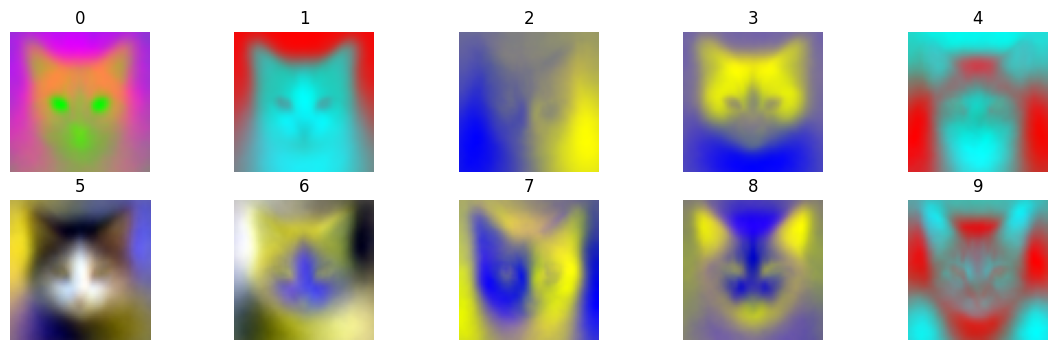

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(14, 4)) # display all 10 images in one plot
for i, img in enumerate(channels_stacked):
    # print(ax.shape) # (2, 5)
    row, col = np.unravel_index(i, ax.shape) # (0, 0), (0, 1), (0, 2) ... (1, 4)
    ax[row, col].set_axis_off()
    ax[row,col].title.set_text(f"{i}")
    ax[row, col].imshow(img) # (M, N, 3): an image with RGB values

## Question 1.3

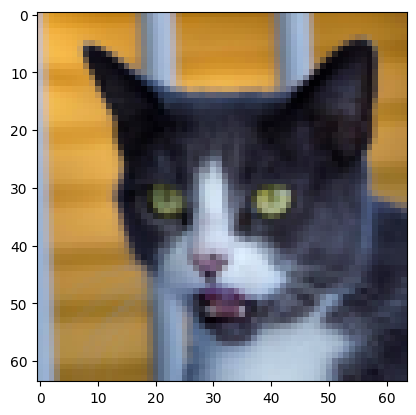

In [33]:
# show the initial image
plot_img = (sec_img - sec_img.min()) / (sec_img.max() - sec_img.min())
plt.imshow(plot_img.reshape((64, 64, 3)))

First, apply dimensionality reduction to the image, i.e. project the image on k principal components


In [34]:
def project(X, mean, pcs, k):
    # projects the image on its k principle components, i.e. does dimensionality reduction
    return (X - mean) @ pcs[:k, :].T

Then, transform image back to its original space (reconstruct)

In [35]:
def reconstruct(X, mean, pcs, k):
    # reconstruct the image, and re-add the mean
    return X @ pcs[:k, :] + mean

Repeat this for each three of the color channel, and for different k values

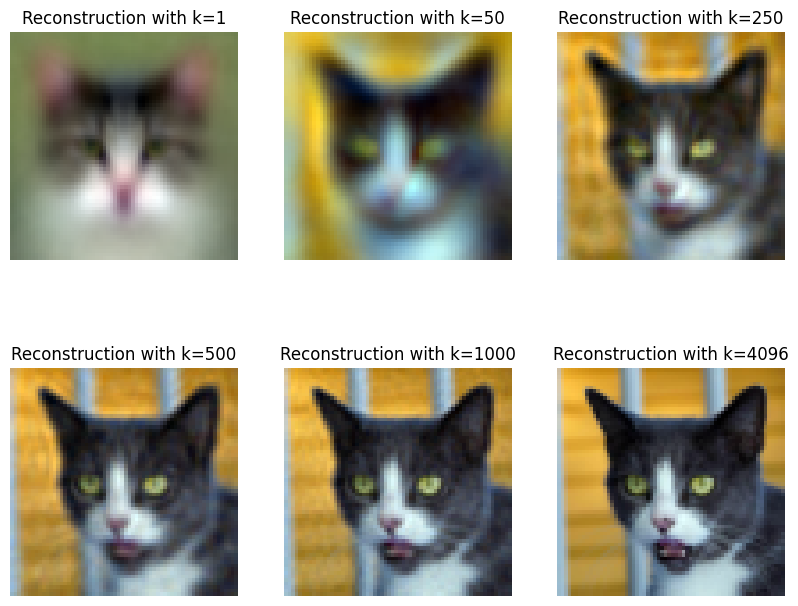

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 8)) # display all 6 images in one plot
img_ctr = 0
ks = [1, 50, 250, 500, 1000, 4096] # k values
pc_ch = [red_pcs, green_pcs, blue_pcs] # principle components for each color channel
mean_ch = [red_mean, green_mean, blue_mean] # means for each color channel

for k in ks:
    img_projected = np.zeros((k, 3))
    for i, pc in enumerate(pc_ch):
        img_projected[:,i] = project(sec_img[:, i], mean_ch[i], pc, k)
    img_reconstructed = np.zeros((4096, 3))
    for i, pc in enumerate(pc_ch):
        img_reconstructed[:,i] = reconstruct(img_projected[:, i], mean_ch[i], pc, k)

    # subplot
    plot_img = (img_reconstructed - np.min(img_reconstructed, axis=0)) / (np.max(img_reconstructed, axis=0) - np.min(img_reconstructed, axis=0))
    row, col = np.unravel_index(img_ctr, ax.shape)
    ax[row, col].imshow(plot_img.reshape((64, 64, 3)))
    ax[row, col].axis("off")
    ax[row,col].title.set_text(f"Reconstruction with k={k}")
    img_ctr += 1

plt.show()